<center> <img src="https://i0.wp.com/cimtrajalisco.org/wp-content/uploads/2019/02/Logo_Horizontal-1024x472.jpg?fit=1024%2C472" align="center" width="800" height="472"/> </center>

<center><font color=#555555><font size=6> PREDICTIVE MODEL FOR FINANCIAL TIME SERIES: CLASSIFICATION MODEL FOR CRYPTOCURRENCIES TRENDS</font> <br> <br>
    
<center><font color=#555555><font size=5> Master of Data Science </font> <br> <br> <br> <br>

<center><font color=#555555><font size=6>Carlos Emilio Carranza Avila, emiliocarranza@iteso.mx </font> <br> <br>
   
<center> <font color= #555555> <font size = 4> Aug.2022 </a> | <font color= #555555> <font size = 4> Repository: <a href='https://github.com/EmilioCarranza/TOG-Binary-Forecasting'>Link</a></font>

<center> <font color= #555555> <font size = 6> PREDICTIVE MODEL FOR FINANCIAL TIME SERIES: </font> <br> <br> <font color= #555555> <font size = 5> CLASSIFICATION MODEL FOR CRYPTOCURRENCIES TRENDS  </font>

Packages:

In [1]:
import pandas as pd
import mplfinance as mpf
from gplearn.genetic import SymbolicRegressor
from sympy import *
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
from cycler import cycler
import category_encoders as ce
from sklearn.naive_bayes import GaussianNB
from IPython.display import Image


# <font color= #6B6B6B> 1. Data Description </font>

<hr style="border:0.02in solid gray"> </hr>

- First we call the datasets that we aquired from data.py and exp.py which can be found on the git hub repository.
- Data ETL:
- OrderBooks, PublicTrades, OnChain (Optional)


In [2]:
# Call new datasets
ordbook = pd.read_parquet('ordbook.parquet')
pubtrade = pd.read_parquet('pubtrade.parquet')
pubtrade = pubtrade[:-1]

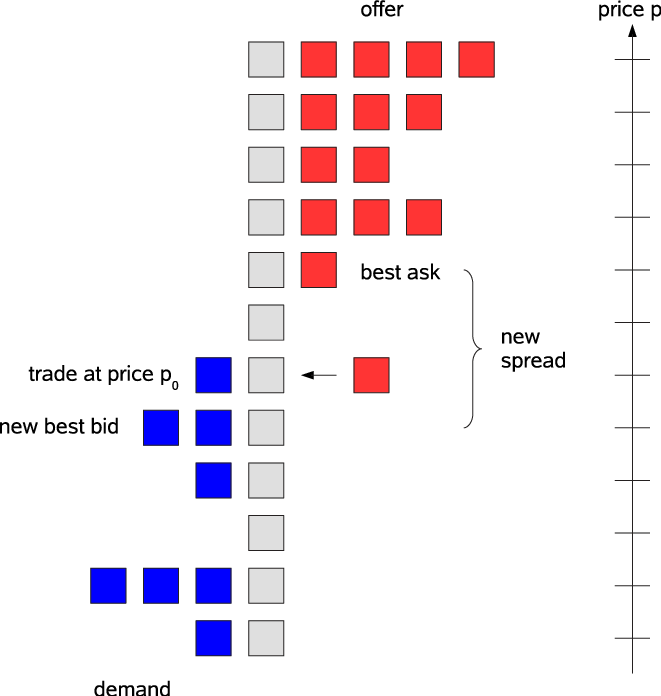

In [3]:
Image("ordbook.png")

In [141]:
ordbook

,timestamp,bid_vol,bid_price,ask_price,ask_vol
0,2022-05-03 03:17:48.222,2.24880,38543.06,38543.07,3.98636
1,2022-05-03 03:17:48.222,0.00500,38542.92,38543.08,0.26144
2,2022-05-03 03:17:48.222,0.80000,38542.91,38543.20,0.80000
3,2022-05-03 03:17:48.222,0.00184,38542.59,38543.21,0.80000
4,2022-05-03 03:17:48.222,0.04930,38542.39,38543.39,0.11641
...,...,...,...,...,...
551795,2022-05-03 03:47:47.512,0.32990,38494.33,38537.20,0.00973
551796,2022-05-03 03:47:47.512,0.01242,38493.83,38537.22,0.00039
551797,2022-05-03 03:47:47.512,0.38956,38493.60,38537.56,0.17516
551798,2022-05-03 03:47:47.512,0.00031,38493.36,38537.69,0.02000


In [142]:
pubtrade

,timestamp,trade_id,side,price,amount
0,2022-05-03 03:45:59.978,1156590004,buy,38510.99,0.00146
1,2022-05-03 03:45:59.979,1156590005,buy,38510.99,0.00127
2,2022-05-03 03:45:59.982,1156590007,sell,38510.98,0.00195
3,2022-05-03 03:45:59.986,1156590008,sell,38510.98,0.00159
4,2022-05-03 03:45:59.988,1156590009,sell,38510.98,0.00043
...,...,...,...,...,...
11129,2022-05-03 04:17:46.169,1156602971,sell,38478.45,0.00123
11130,2022-05-03 04:17:46.875,1156602972,sell,38478.45,0.00298
11131,2022-05-03 04:17:46.929,1156602973,buy,38478.46,0.00054
11132,2022-05-03 04:17:47.138,1156602974,sell,38478.45,0.00048


- Data Pre-processing:
    - Datos faltantes
    - Resampleo, iid
    - Scaling, normalizar, estandarizar


In [143]:
ordbook.isna().sum()

timestamp    0
bid_vol      0
bid_price    0
ask_price    0
ask_vol      0
dtype: int64

In [144]:
pubtrade.isnull().sum()

timestamp    0
trade_id     0
side         0
price        0
amount       0
dtype: int64

# <font color= #6B6B6B> 2. Feature Engineering </font>

<hr style="border:0.02in solid gray"> </hr>

* Target / Feature engineering, importance, selection:
    - FE: Transformaciones lineales con OHLC
    - FI: Correlacion entre variables explicativas y variable objetivo
    - FS: Definir un criterio tipo Umbral o Threshold, Co-linealidad


Next we will create a new table with the spreads of both bid and ask prices,
- $spread = AS-BS $ 
- With this we can create a new column named mid price.
- $ MP= (Ask+Bid)/2$

In [8]:
# Spread ask price-bid price

bid_spread = ordbook.groupby(ordbook['timestamp'], group_keys=False)['bid_price'].max()
ask_spread = ordbook.groupby(ordbook['timestamp'], group_keys=False)['ask_price'].max()

spread_table = pd.merge(bid_spread, ask_spread, on='timestamp')
spread_table['Spread'] = spread_table['ask_price'] - spread_table['bid_price']
spread_table['basis points'] = spread_table['Spread'] * 10000

# mid-price (promedio entre ask y bid)

spread_table['mid_price'] = (spread_table['ask_price'] + spread_table['bid_price']) * 0.5

spread_table

,bid_price,ask_price,Spread,basis points,mid_price
timestamp,,,,,
2022-05-03 03:17:48.222,38543.06,38574.46,31.40,314000.0,38558.760
2022-05-03 03:17:48.571,38543.06,38575.73,32.67,326700.0,38559.395
2022-05-03 03:17:48.909,38543.06,38575.24,32.18,321800.0,38559.150
2022-05-03 03:17:49.263,38543.06,38574.69,31.63,316300.0,38558.875
2022-05-03 03:17:49.609,38543.06,38575.73,32.67,326700.0,38559.395
...,...,...,...,...,...
2022-05-03 03:47:46.448,38510.99,38538.00,27.01,270100.0,38524.495
2022-05-03 03:47:46.721,38510.99,38537.94,26.95,269500.0,38524.465
2022-05-03 03:47:46.985,38510.99,38537.94,26.95,269500.0,38524.465


- Then we create another table called VWAP which is the Volume-weighted average price, which is the average price of the finantial instrument based on both volume and price.

In [9]:
vwap = ordbook.copy()

vwap['volask'] = vwap['ask_price'] * vwap['ask_vol']
vwap['volbid'] = vwap['bid_price'] * vwap['bid_vol']
vwap['total_vol'] = vwap['ask_vol'] + vwap['bid_vol']
vwap['imb_dif'] = vwap['bid_vol'] - vwap['ask_vol']

vwap_grouped = vwap.groupby('timestamp').sum()
vwap_grouped['vwap'] = (vwap_grouped['volask'] + vwap_grouped['volbid']) / vwap_grouped['total_vol']
vwap_grouped

,bid_vol,bid_price,ask_price,ask_vol,volask,volbid,total_vol,imb_dif,vwap
timestamp,,,,,,,,,
2022-05-03 03:17:48.222,28.62652,3853012.98,3855846.58,38.30427,1.477010e+06,1.103043e+06,66.93079,-9.67775,38548.079019
2022-05-03 03:17:48.571,29.70723,3853055.42,3855925.78,39.10900,1.508025e+06,1.144697e+06,68.81623,-9.40177,38547.909570
2022-05-03 03:17:48.909,29.67274,3853055.42,3855903.87,40.04327,1.544035e+06,1.143368e+06,69.71601,-10.37053,38547.859282
2022-05-03 03:17:49.263,28.06614,3853018.04,3855884.70,40.65842,1.567739e+06,1.081445e+06,68.72456,-12.59228,38547.850671
2022-05-03 03:17:49.609,25.01113,3852937.27,3855911.71,40.57734,1.564614e+06,9.636995e+05,65.58847,-15.56621,38548.138685
...,...,...,...,...,...,...,...,...,...
2022-05-03 03:47:46.448,18.68495,3850156.76,3852324.07,32.30793,1.244466e+06,7.193764e+05,50.99288,-13.62298,38512.085448
2022-05-03 03:47:46.721,17.48912,3850151.93,3852314.61,34.86985,1.343173e+06,6.733357e+05,52.35897,-17.38073,38513.142734
2022-05-03 03:47:46.985,17.63624,3850156.00,3852314.61,34.86985,1.343173e+06,6.790006e+05,52.50609,-17.23361,38513.120599


In [10]:
# Public trade features
trades = (len(pubtrade))
total_volume = (pubtrade['amount']).sum()
print('Total Trades:',trades)
print(Counter(pubtrade['side']))


Total Trades: 11134
Counter({'buy': 6055, 'sell': 5079})


In [11]:
stats = ordbook.copy()
stats = stats.groupby('timestamp').sum()
stats

,bid_vol,bid_price,ask_price,ask_vol
timestamp,,,,
2022-05-03 03:17:48.222,28.62652,3853012.98,3855846.58,38.30427
2022-05-03 03:17:48.571,29.70723,3853055.42,3855925.78,39.10900
2022-05-03 03:17:48.909,29.67274,3853055.42,3855903.87,40.04327
2022-05-03 03:17:49.263,28.06614,3853018.04,3855884.70,40.65842
2022-05-03 03:17:49.609,25.01113,3852937.27,3855911.71,40.57734
...,...,...,...,...
2022-05-03 03:47:46.448,18.68495,3850156.76,3852324.07,32.30793
2022-05-03 03:47:46.721,17.48912,3850151.93,3852314.61,34.86985
2022-05-03 03:47:46.985,17.63624,3850156.00,3852314.61,34.86985


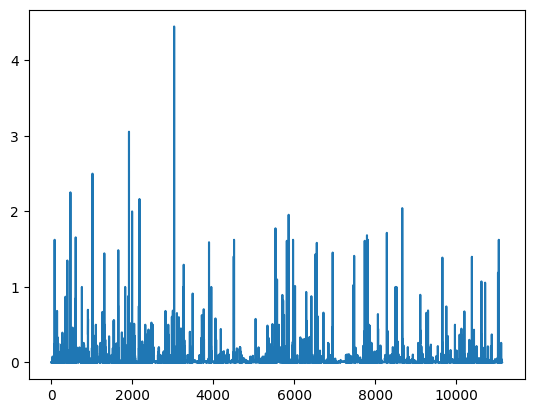

In [12]:
# 3.- Time series plot (lines)
series_pubtrade_amount = pubtrade['amount'].astype(float)
series_pubtrade_amount.plot()
pyplot.show()

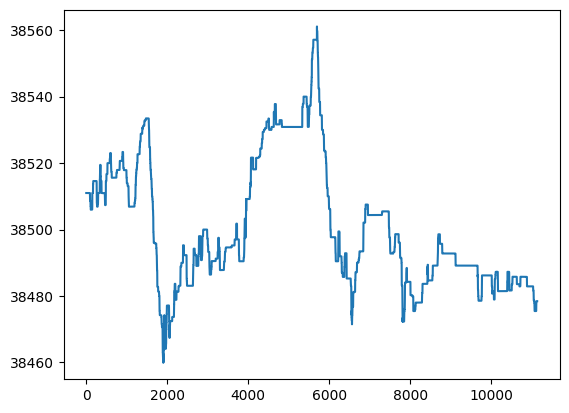

In [13]:
# Time series plot for price
series_pubtrade_price = pubtrade['price'].astype(float)
series_pubtrade_price.plot()
pyplot.show()

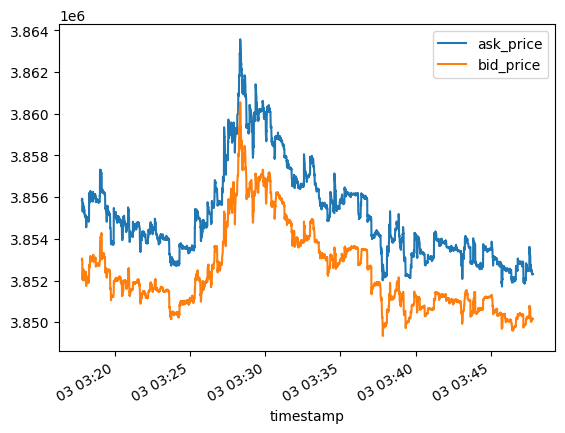

In [14]:
# Time series plot for price
series_pubtrade_price = pubtrade['price'].astype(float)
series_pubtrade_price.plot()
pyplot.show()

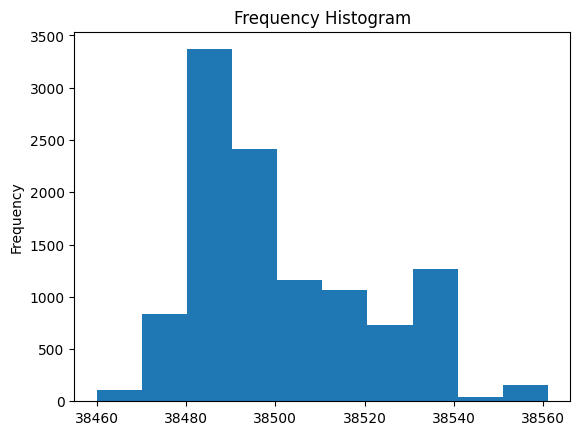

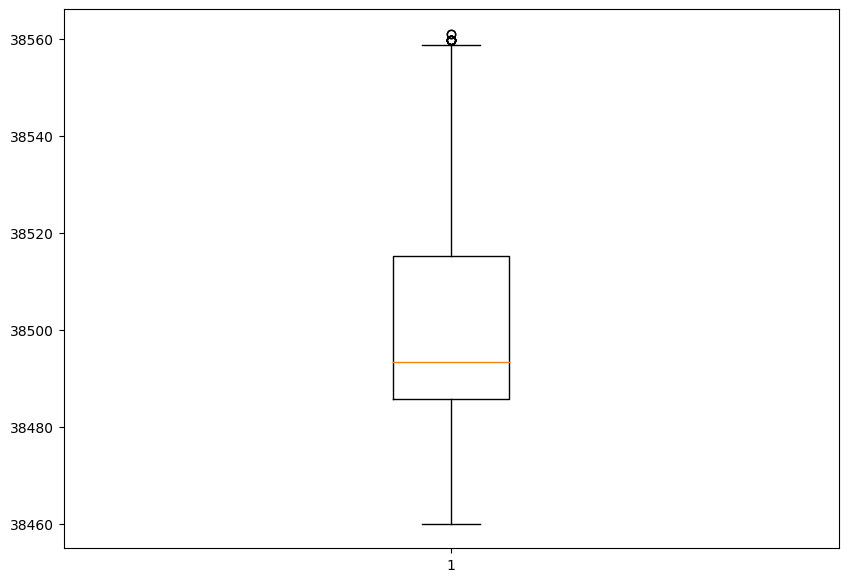

In [15]:
# Histograma Frecuencia de Variables

plt.hist(series_pubtrade_price, bins=10)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')
# 5.- Boxplot (con media y mediana)
fig = plt.figure(figsize=(10, 7))

# Creating plot
plt.boxplot(series_pubtrade_price)

# show plot
plt.show()

### Creating the OHLCV dataset
OHLCV is an aggregated form of the market data, it stands for Open, High, Low, Close, and Volume.
* Open: The first price in the epoch.
* High: The highest price on the epoch.
* Low: The lowest point in the period.
* Close: The final price on the period.
* Volume: the total volume during the period.

The dataset is formed with the volume per period and the midprice of such period.

In [59]:
#OHLCV

ohlcv = spread_table['mid_price'].resample('1S').ohlc()
time = ohlcv.index
ohlcv['volume'] = vwap_grouped['total_vol'].resample('1S').sum()
ohlcv

,open,high,low,close,volume
timestamp,,,,,
2022-05-03 03:17:48,38558.760,38559.395,38558.760,38559.150,205.46303
2022-05-03 03:17:49,38558.875,38559.395,38558.015,38558.015,203.21216
2022-05-03 03:17:50,38555.840,38555.840,38555.500,38555.500,139.37039
2022-05-03 03:17:51,38554.840,38555.600,38554.840,38555.600,227.60544
2022-05-03 03:17:52,38555.710,38557.180,38555.710,38557.180,212.77384
...,...,...,...,...,...
2022-05-03 03:47:43,38525.340,38525.390,38525.340,38525.340,218.76370
2022-05-03 03:47:44,38525.065,38525.065,38524.530,38524.530,164.29418
2022-05-03 03:47:45,38524.530,38524.660,38524.465,38524.465,161.00105


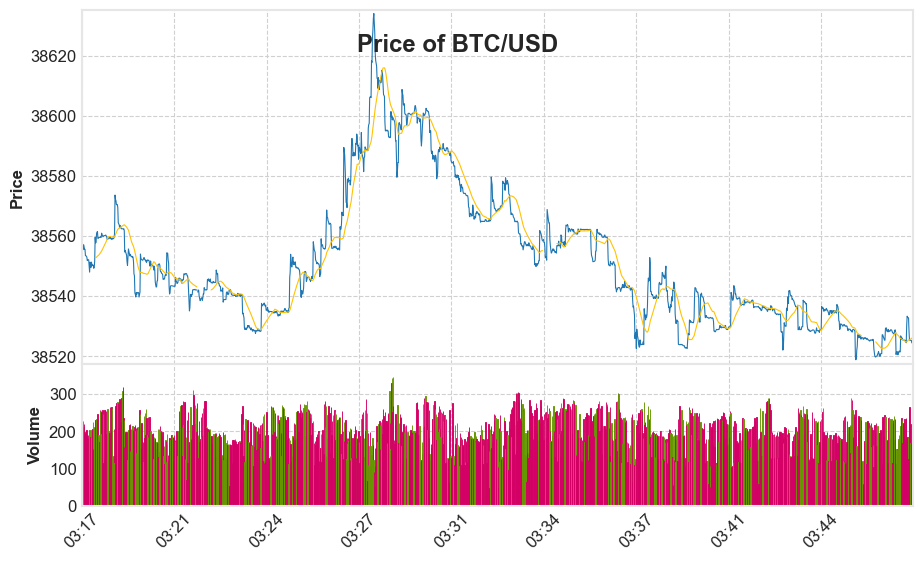

In [14]:
TICKER = 'BTC/USD'
mpf.plot(ohlcv, figratio=(10, 6), type="line",
         mav=30, volume=True,
         title=f"Price of {TICKER}",
         tight_layout=True, style="binance")

Next we will create the first features based on the OHLCV dataset.
* Volatility(HL):  $ V_t=H_t-L_t$
* High - open(HO): $ HO_t=H_t-O_t$
* Open - low(OL):  $ OL_t=O_t-L_t$
* High - Low(HL):  $ HL_t=H_t-L_t $
* Close - Open(CO): $CO_t=C_t-O_t$



In [60]:
# Volatility
volatility = []
for i in range(len(ohlcv)):
    vol = ohlcv['high'][i] - ohlcv['low'][i]
    volatility.append(vol)
ohlcv['volatility'] = volatility

# micro trends
high_open = []
for i in range(len(ohlcv)):
    ho = ohlcv['high'][i] - ohlcv['open'][i]
    high_open.append(ho)
ohlcv['high_open'] = high_open

open_low = []
for i in range(len(ohlcv)):
    ol = ohlcv['open'][i] - ohlcv['low'][i]
    open_low.append(ol)
ohlcv['open_low'] = open_low

high_low = []  # micro volatility
for i in range(len(ohlcv)):
    hl = ohlcv['high'][i] - ohlcv['low'][i]
    high_low.append(hl)
ohlcv['high_low'] = high_low

close_open = []
for i in range(len(ohlcv)):
    co = ohlcv['close'][i] - ohlcv['open'][i]
    close_open.append(co)
ohlcv['close_open'] = close_open
ohlcv

,open,high,low,close,volume,volatility,high_open,open_low,high_low,close_open
timestamp,,,,,,,,,,
2022-05-03 03:17:48,38558.760,38559.395,38558.760,38559.150,205.46303,0.635,0.635,0.000,0.635,0.390
2022-05-03 03:17:49,38558.875,38559.395,38558.015,38558.015,203.21216,1.380,0.520,0.860,1.380,-0.860
2022-05-03 03:17:50,38555.840,38555.840,38555.500,38555.500,139.37039,0.340,0.000,0.340,0.340,-0.340
2022-05-03 03:17:51,38554.840,38555.600,38554.840,38555.600,227.60544,0.760,0.760,0.000,0.760,0.760
2022-05-03 03:17:52,38555.710,38557.180,38555.710,38557.180,212.77384,1.470,1.470,0.000,1.470,1.470
...,...,...,...,...,...,...,...,...,...,...
2022-05-03 03:47:43,38525.340,38525.390,38525.340,38525.340,218.76370,0.050,0.050,0.000,0.050,0.000
2022-05-03 03:47:44,38525.065,38525.065,38524.530,38524.530,164.29418,0.535,0.000,0.535,0.535,-0.535
2022-05-03 03:47:45,38524.530,38524.660,38524.465,38524.465,161.00105,0.195,0.130,0.065,0.195,-0.065


# <font color= #6B6B6B> 3. Target Engineering: Classification problem sign  </font>

<hr style="border:0.02in solid gray"> </hr>

Our target feature will be called sign, sign is the micro-trend $CO_t$ which will be represented in a binary way, as a 0 or 1.
* -1 = down trend.
* 0 = plateau.
* 1 = Up trend.

This will permit us to see the direction of the trend in price per epoch.

In [131]:
ohlc = pd.DataFrame(ohlcv)

sign = []

for i in range(len(ohlc)):
    sign1 = ohlc["close"][i] - ohlc["open"][i]
    sign.append(sign1)
for i in range(len(ohlc)):
    if sign[i] < -1.5:
        sign[i] = -2
    elif -1.5 <= sign[i] < 0:
        sign[i] = -1
    elif sign[i] == 0:
        sign[i]= 0
    elif 0 > sign[i] > 1.5:
        sign[i] = 1
    else: sign[i] = 2

ohlc['sign'] = sign
sign_test = sign
ohlc

,open,high,low,close,volume,volatility,high_open,open_low,high_low,close_open,sign,martingale
timestamp,,,,,,,,,,,,
2022-05-03 03:17:48,38558.760,38559.395,38558.760,38559.150,205.46303,0.635,0.635,0.000,0.635,0.390,2,NaN
2022-05-03 03:17:49,38558.875,38559.395,38558.015,38558.015,203.21216,1.380,0.520,0.860,1.380,-0.860,-1,2.0
2022-05-03 03:17:50,38555.840,38555.840,38555.500,38555.500,139.37039,0.340,0.000,0.340,0.340,-0.340,-1,2.0
2022-05-03 03:17:51,38554.840,38555.600,38554.840,38555.600,227.60544,0.760,0.760,0.000,0.760,0.760,2,-1.0
2022-05-03 03:17:52,38555.710,38557.180,38555.710,38557.180,212.77384,1.470,1.470,0.000,1.470,1.470,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 03:47:43,38525.340,38525.390,38525.340,38525.340,218.76370,0.050,0.050,0.000,0.050,0.000,0,2.0
2022-05-03 03:47:44,38525.065,38525.065,38524.530,38524.530,164.29418,0.535,0.000,0.535,0.535,-0.535,-1,0.0
2022-05-03 03:47:45,38524.530,38524.660,38524.465,38524.465,161.00105,0.195,0.130,0.065,0.195,-0.065,-1,2.0


In [132]:
ohlc['sign'] = sign
ohlc['sign'] = ohlc['sign'].shift(-1)
#ohlc.dropna(inplace = True, axis=0)
ohlc

,open,high,low,close,volume,volatility,high_open,open_low,high_low,close_open,sign,martingale
timestamp,,,,,,,,,,,,
2022-05-03 03:17:48,38558.760,38559.395,38558.760,38559.150,205.46303,0.635,0.635,0.000,0.635,0.390,-1.0,NaN
2022-05-03 03:17:49,38558.875,38559.395,38558.015,38558.015,203.21216,1.380,0.520,0.860,1.380,-0.860,-1.0,2.0
2022-05-03 03:17:50,38555.840,38555.840,38555.500,38555.500,139.37039,0.340,0.000,0.340,0.340,-0.340,2.0,2.0
2022-05-03 03:17:51,38554.840,38555.600,38554.840,38555.600,227.60544,0.760,0.760,0.000,0.760,0.760,2.0,-1.0
2022-05-03 03:17:52,38555.710,38557.180,38555.710,38557.180,212.77384,1.470,1.470,0.000,1.470,1.470,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 03:47:43,38525.340,38525.390,38525.340,38525.340,218.76370,0.050,0.050,0.000,0.050,0.000,-1.0,2.0
2022-05-03 03:47:44,38525.065,38525.065,38524.530,38524.530,164.29418,0.535,0.000,0.535,0.535,-0.535,-1.0,0.0
2022-05-03 03:47:45,38524.530,38524.660,38524.465,38524.465,161.00105,0.195,0.130,0.065,0.195,-0.065,-1.0,2.0


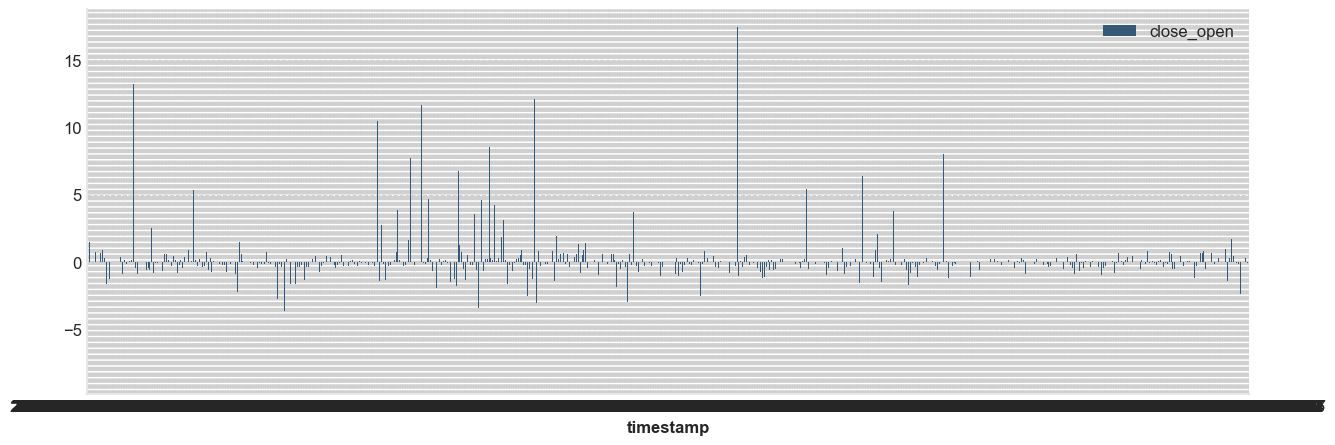

In [63]:

ax = ohlc.plot.bar(y='close_open',rot=0)

In [133]:
ohlc['sign'].value_counts()

-1.0    728
 2.0    621
 0.0    362
-2.0     88
Name: sign, dtype: int64

# <font color= #6B6B6B> 4. Target Engineering: Benchmarks  </font>

First we will perform our first benchmark, the martingale, this method says that the price in $$E[X_{t}] = E[X_{t-1}]$$

In [134]:
mart = []

for i in range(len(ohlc)):
    sign1 = ohlc["close"][i] - ohlc["open"][i]
    mart.append(sign1)
for i in range(len(ohlc)):
    if mart[i] < -1.5:
        mart[i] = -2
    elif -1.5 <= mart[i] < 0:
        mart[i] = -1
    elif mart[i] == 0:
        mart[i]= 0
    elif 0 > mart[i] > 1.5:
        mart[i] = 1
    else: mart[i] = 2


In [135]:
# Martingale

ohlc['martingale'] = mart
ohlc['martingale'] = ohlc['martingale'].shift(+1)
ohlc = ohlc.fillna(0)
ohlc['martingale']
ohlc2 = pd.DataFrame(ohlc)
ohlc2.to_csv('C:/Users/Emilio/Desktop/Thesis/ohlc2.csv')
ohlc2

,open,high,low,close,volume,volatility,high_open,open_low,high_low,close_open,sign,martingale
timestamp,,,,,,,,,,,,
2022-05-03 03:17:48,38558.760,38559.395,38558.760,38559.150,205.46303,0.635,0.635,0.000,0.635,0.390,-1.0,0.0
2022-05-03 03:17:49,38558.875,38559.395,38558.015,38558.015,203.21216,1.380,0.520,0.860,1.380,-0.860,-1.0,2.0
2022-05-03 03:17:50,38555.840,38555.840,38555.500,38555.500,139.37039,0.340,0.000,0.340,0.340,-0.340,2.0,-1.0
2022-05-03 03:17:51,38554.840,38555.600,38554.840,38555.600,227.60544,0.760,0.760,0.000,0.760,0.760,2.0,-1.0
2022-05-03 03:17:52,38555.710,38557.180,38555.710,38557.180,212.77384,1.470,1.470,0.000,1.470,1.470,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 03:47:43,38525.340,38525.390,38525.340,38525.340,218.76370,0.050,0.050,0.000,0.050,0.000,-1.0,2.0
2022-05-03 03:47:44,38525.065,38525.065,38524.530,38524.530,164.29418,0.535,0.000,0.535,0.535,-0.535,-1.0,0.0
2022-05-03 03:47:45,38524.530,38524.660,38524.465,38524.465,161.00105,0.195,0.130,0.065,0.195,-0.065,-1.0,-1.0


In [136]:
ohlc['martingale'].value_counts()

-1.0    728
 2.0    622
 0.0    362
-2.0     88
Name: martingale, dtype: int64

In [138]:
accuracy_martingala = accuracy_score(sign_test, ohlc2['martingale']) * 100
print(accuracy_martingala)
confusion_mart=confusion_matrix(ohlc2['sign'], ohlc2['martingale'])
confusion_mart

32.0


array([[  8,  37,  20,  23],
       [ 26, 285, 140, 277],
       [  9, 149,  87, 118],
       [ 45, 257, 115, 204]], dtype=int64)

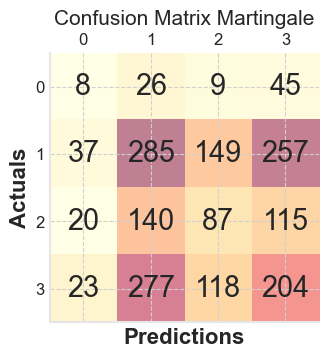

In [139]:
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(confusion_mart, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mart.shape[0]):
    for n in range(confusion_mart.shape[1]):
        px.text(x=m,y=n,s=confusion_mart[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Martingale', fontsize=15)
plt.show()

# <font color= #6B6B6B> 4.2. Naive Bayes and Logistic Regression   </font>


* Regression
* Naive Bayes

For the next benchmark a Logistic Regresion was chosen, the reason being that the target variable is categorical in nature, being a binary variable composed of an array of 0 and 1.

The first step for this benchmark is to create a heatmap which will represent the relationship between the variables.

* Heat Map

                open      high       low     close    volume  volatility  \
open        1.000000  1.000000  1.000000  1.000000  0.146732    0.021829   
high        1.000000  1.000000  1.000000  1.000000  0.146812    0.022498   
low         1.000000  1.000000  1.000000  1.000000  0.146683    0.021579   
close       1.000000  1.000000  1.000000  1.000000  0.146765    0.022248   
volume      0.146732  0.146812  0.146683  0.146765  1.000000    0.143403   
volatility  0.021829  0.022498  0.021579  0.022248  0.143403    1.000000   
high_open   0.012678  0.013490  0.012732  0.013533  0.100335    0.824713   
open_low    0.018698  0.018614  0.018175  0.018108  0.096357    0.477703   
high_low    0.021829  0.022498  0.021579  0.022248  0.143403    1.000000   
close_open  0.000521  0.001216  0.000830  0.001519  0.033750    0.419775   
sign       -0.024333 -0.024388 -0.024339 -0.024390 -0.013518   -0.053874   
martingale  0.016047  0.016074  0.016034  0.016063  0.008006    0.043497   

           

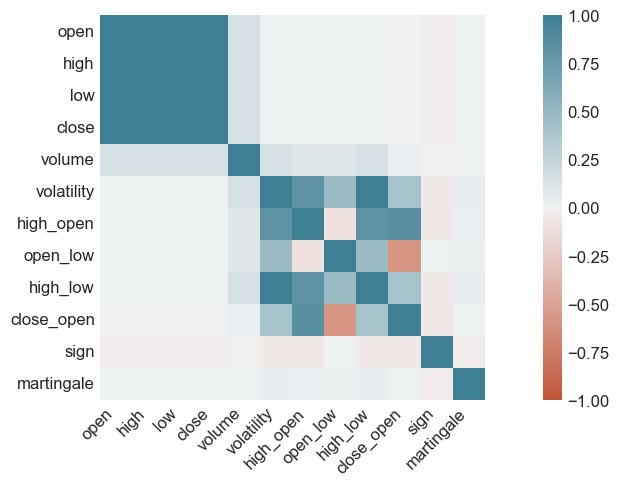

In [78]:
# Heat map
correlation = ohlc2.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

* pair plot

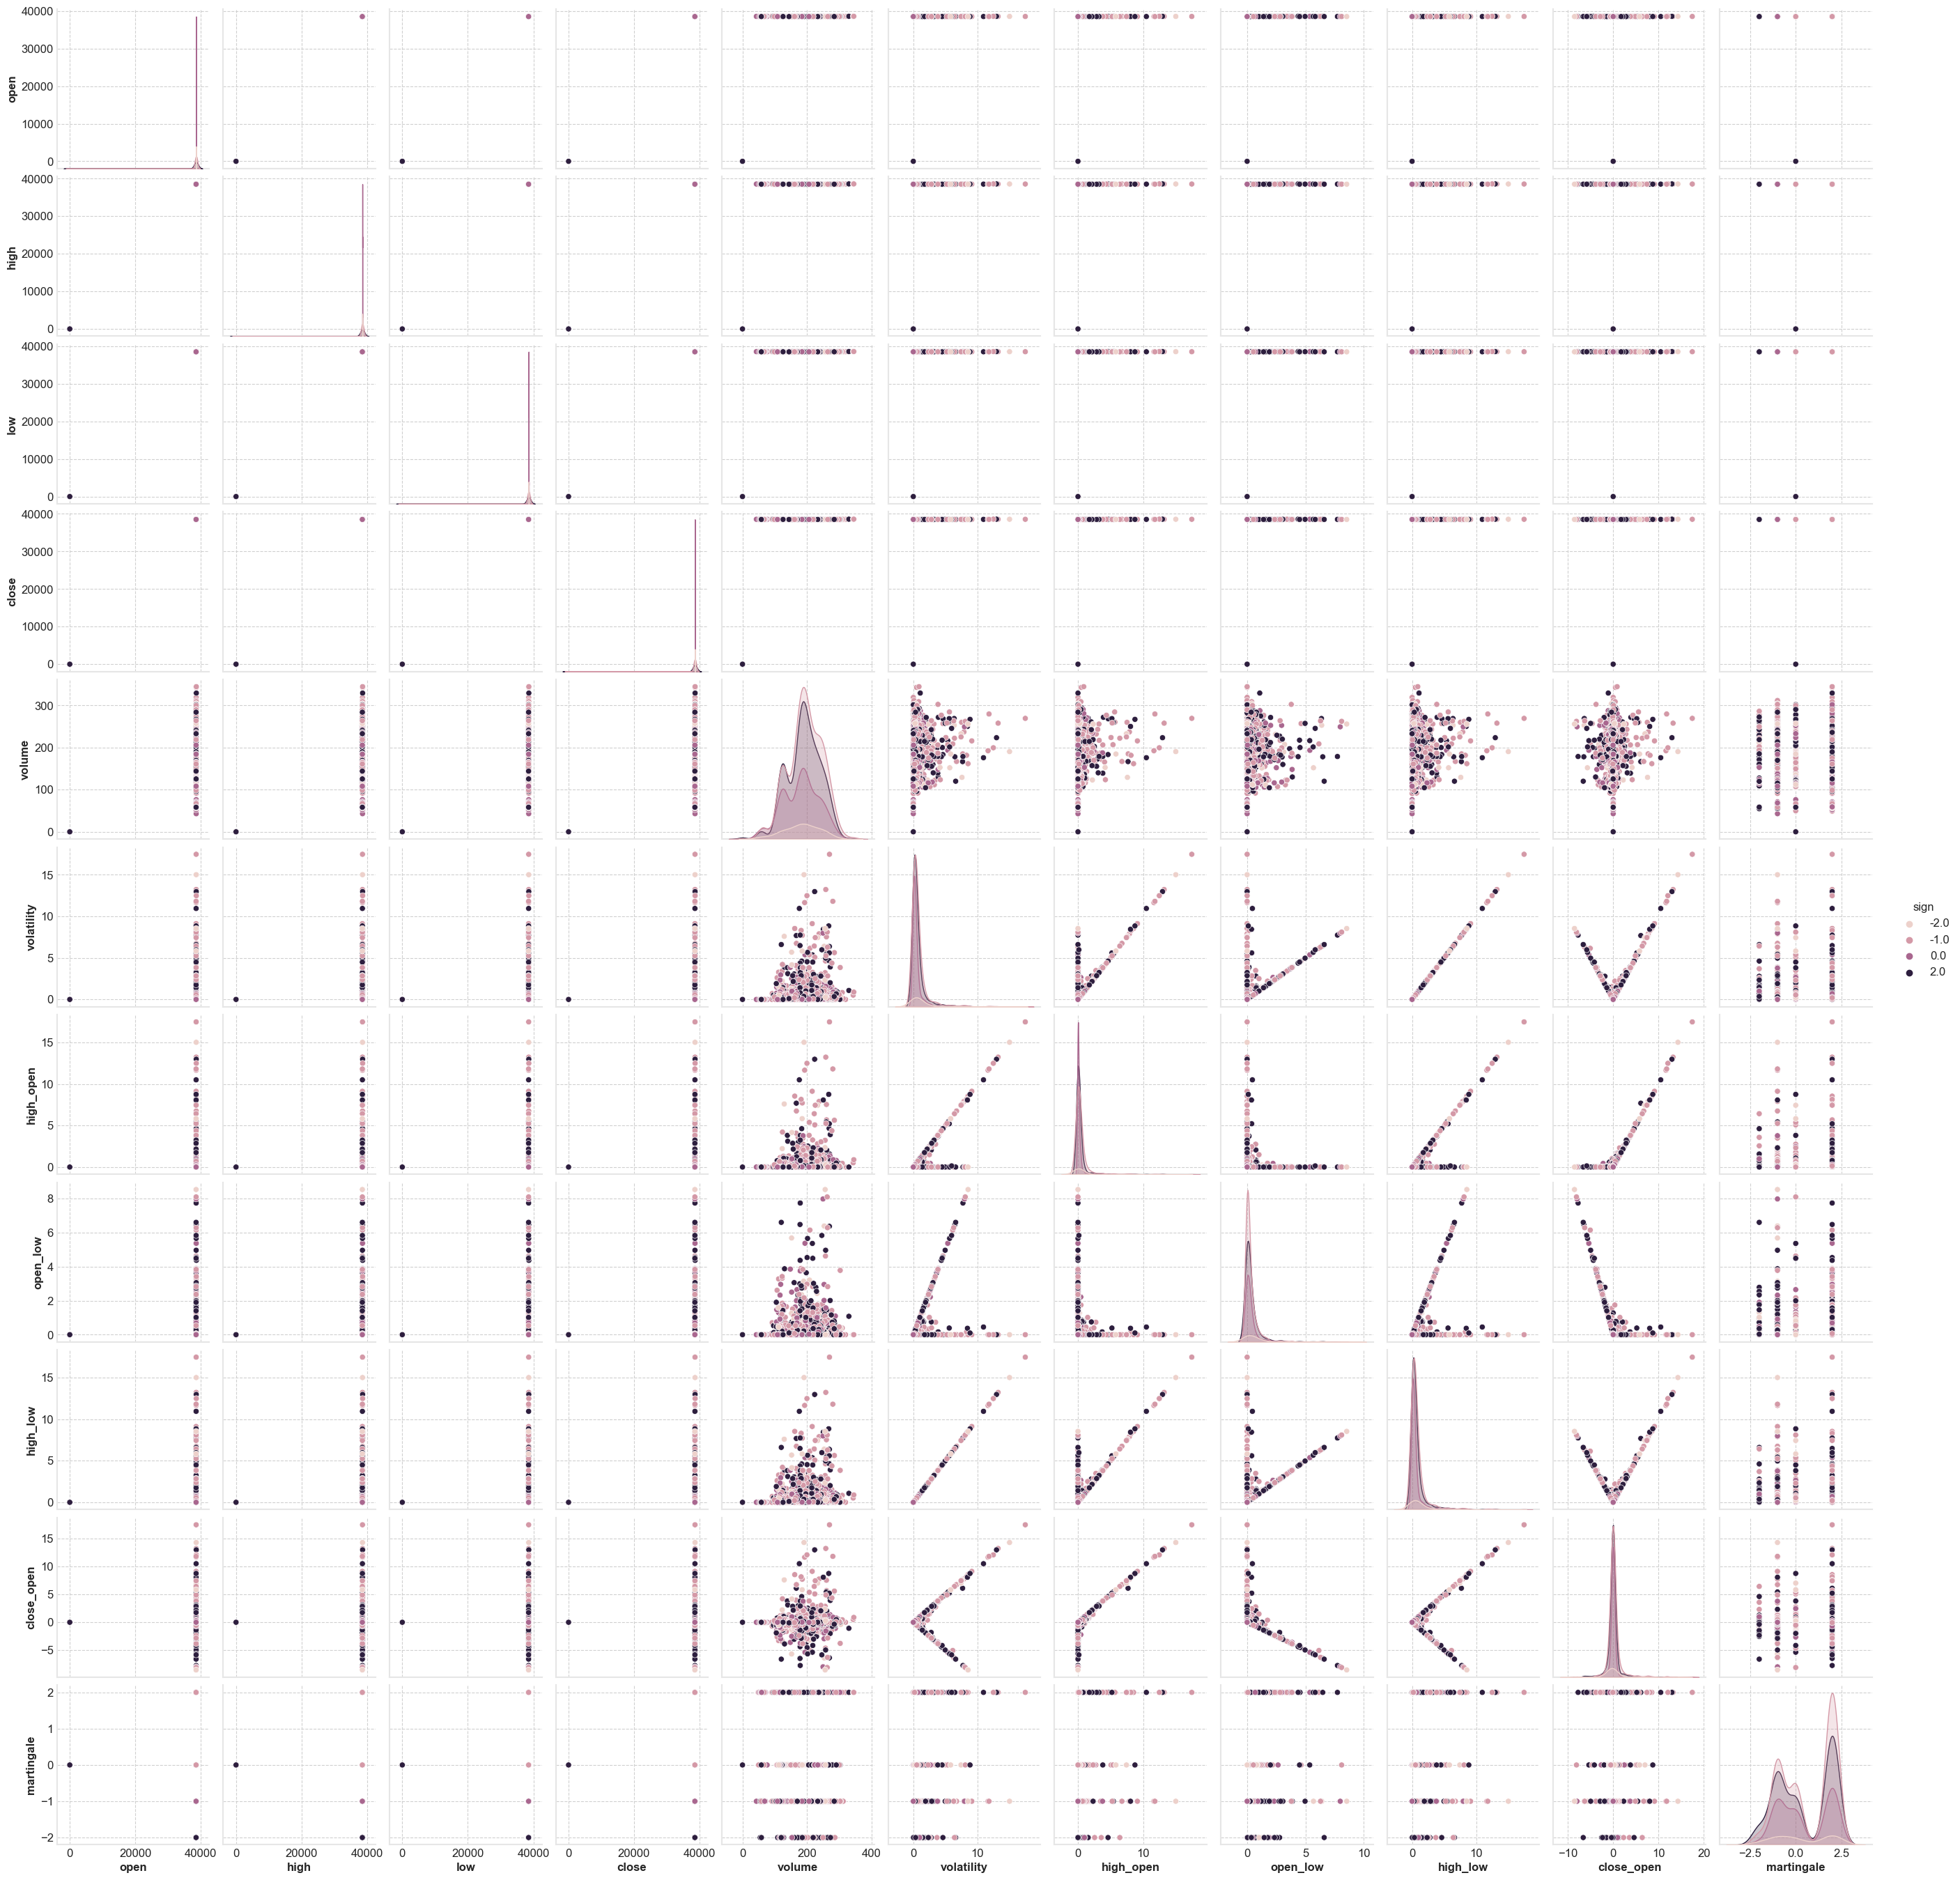

In [79]:
sns.pairplot(ohlc2, hue='sign', height=2.5)

In [83]:
ma = ohlc2.rolling(5).mean()
std = ohlc2.std()
ma,std

(                          open       high        low      close      volume  \
 timestamp                                                                     
 2022-05-03 03:17:48        NaN        NaN        NaN        NaN         NaN   
 2022-05-03 03:17:49        NaN        NaN        NaN        NaN         NaN   
 2022-05-03 03:17:50        NaN        NaN        NaN        NaN         NaN   
 2022-05-03 03:17:51        NaN        NaN        NaN        NaN         NaN   
 2022-05-03 03:17:52  38556.805  38557.482  38556.565  38557.089  197.684972   
 ...                        ...        ...        ...        ...         ...   
 2022-05-03 03:47:43  38525.933  38526.008  38525.243  38525.361  207.460744   
 2022-05-03 03:47:44  38525.302  38525.377  38525.070  38525.188  187.532026   
 2022-05-03 03:47:45  38525.068  38525.169  38524.895  38525.013  175.956158   
 2022-05-03 03:47:46  38524.900  38524.990  38524.774  38524.828  183.194112   
 2022-05-03 03:47:47  38524.779  38524.8

In [140]:
# Preprocessing Log, Scale, Standardize (mean, median), Normalize
X = ohlc2.iloc[:, 4:-2]
y = ohlc2['sign']
y_true = y
X

,volume,volatility,high_open,open_low,high_low,close_open
timestamp,,,,,,
2022-05-03 03:17:48,205.46303,0.635,0.635,0.000,0.635,0.390
2022-05-03 03:17:49,203.21216,1.380,0.520,0.860,1.380,-0.860
2022-05-03 03:17:50,139.37039,0.340,0.000,0.340,0.340,-0.340
2022-05-03 03:17:51,227.60544,0.760,0.760,0.000,0.760,0.760
2022-05-03 03:17:52,212.77384,1.470,1.470,0.000,1.470,1.470
...,...,...,...,...,...,...
2022-05-03 03:47:43,218.76370,0.050,0.050,0.000,0.050,0.000
2022-05-03 03:47:44,164.29418,0.535,0.000,0.535,0.535,-0.535
2022-05-03 03:47:45,161.00105,0.195,0.130,0.065,0.195,-0.065


To use the data in the log regression we require to fit the data trought transformations as the data has different scales which would give us a bad forecast.

* The first one is the Normalizer which transforms numeric columns to a standard scale. in this instance it is done by the maximum absolute scaling method which has the following formula:
$$ x_{scaled} =\frac{ x}{max(|x|)} $$

In [86]:
# Normalizer
transformer = Normalizer(norm= 'max').fit(X) 
transformed = transformer.transform(X)
X_normalized = pd.DataFrame(transformed,index = X.index, columns= X.columns)
X_normalized 

,volume,volatility,high_open,open_low,high_low,close_open
timestamp,,,,,,
2022-05-03 03:17:48,1.0,0.003091,0.003091,0.000000,0.003091,0.001898
2022-05-03 03:17:49,1.0,0.006791,0.002559,0.004232,0.006791,-0.004232
2022-05-03 03:17:50,1.0,0.002440,0.000000,0.002440,0.002440,-0.002440
2022-05-03 03:17:51,1.0,0.003339,0.003339,0.000000,0.003339,0.003339
2022-05-03 03:17:52,1.0,0.006909,0.006909,0.000000,0.006909,0.006909
...,...,...,...,...,...,...
2022-05-03 03:47:43,1.0,0.000229,0.000229,0.000000,0.000229,0.000000
2022-05-03 03:47:44,1.0,0.003256,0.000000,0.003256,0.003256,-0.003256
2022-05-03 03:47:45,1.0,0.001211,0.000807,0.000404,0.001211,-0.000404


The second method chosen was Min Max Scaler, which transforms the features by scaling them to a given range in this case 0 to 1.

$$ X_{norm}= \frac{X-X_{min}} {X_{max}-X_{min}} $$

In [87]:
#  Min Max Scaler
scale = MinMaxScaler()
X_scale = scale.fit(X)
X_scale = scale.transform(X)
X_scale = pd.DataFrame(X_scale,index = X.index, columns= X.columns)
X_scale

,volume,volatility,high_open,open_low,high_low,close_open
timestamp,,,,,,
2022-05-03 03:17:48,0.595999,0.036358,0.036358,0.000000,0.036358,0.343269
2022-05-03 03:17:49,0.589470,0.079015,0.029774,0.100762,0.079015,0.295192
2022-05-03 03:17:50,0.404280,0.019468,0.000000,0.039836,0.019468,0.315192
2022-05-03 03:17:51,0.660229,0.043516,0.043516,0.000000,0.043516,0.357500
2022-05-03 03:17:52,0.617206,0.084168,0.084168,0.000000,0.084168,0.384808
...,...,...,...,...,...,...
2022-05-03 03:47:43,0.634582,0.002863,0.002863,0.000000,0.002863,0.328269
2022-05-03 03:47:44,0.476578,0.030633,0.000000,0.062683,0.030633,0.307692
2022-05-03 03:47:45,0.467026,0.011165,0.007443,0.007616,0.011165,0.325769


The last one is the standardization method, which removes the mean and sacales to unit variance.

$$ Z=\frac{(X-u)}{S} $$
where:
* U = mean of the training samples 
* S= Standard deviation

In [88]:
# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X_standard = pd.DataFrame(scaled,index = X.index, columns= X.columns)
X_standard

,volume,volatility,high_open,open_low,high_low,close_open
timestamp,,,,,,
2022-05-03 03:17:48,0.314831,-0.055111,0.207878,-0.419843,-0.055111,0.234009
2022-05-03 03:17:49,0.272229,0.460020,0.117846,0.626024,0.460020,-0.562283
2022-05-03 03:17:50,-0.936102,-0.259089,-0.289255,-0.006361,-0.259089,-0.231026
2022-05-03 03:17:51,0.733919,0.031321,0.305739,-0.419843,0.031321,0.469712
2022-05-03 03:17:52,0.453202,0.522251,0.861587,-0.419843,0.522251,0.922006
...,...,...,...,...,...,...
2022-05-03 03:47:43,0.566572,-0.459609,-0.250110,-0.419843,-0.459609,-0.014434
2022-05-03 03:47:44,-0.464370,-0.124256,-0.289255,0.230783,-0.124256,-0.355247
2022-05-03 03:47:45,-0.526699,-0.359349,-0.187479,-0.340795,-0.359349,-0.055841


              volume  volatility  high_open  open_low  high_low  close_open  \
volume      1.000000    0.265204   0.148964  0.188826  0.265204   -0.036402   
volatility  0.265204    1.000000   0.375820  0.486073  1.000000   -0.107413   
high_open   0.148964    0.375820   1.000000 -0.514870  0.375820    0.781490   
open_low    0.188826    0.486073  -0.514870  1.000000  0.486073   -0.828975   
high_low    0.265204    1.000000   0.375820  0.486073  1.000000   -0.107413   
close_open -0.036402   -0.107413   0.781490 -0.828975 -0.107413    1.000000   
Sign       -0.024318   -0.076543  -0.061772  0.011600 -0.076543   -0.032119   

                Sign  
volume     -0.024318  
volatility -0.076543  
high_open  -0.061772  
open_low    0.011600  
high_low   -0.076543  
close_open -0.032119  
Sign        1.000000  


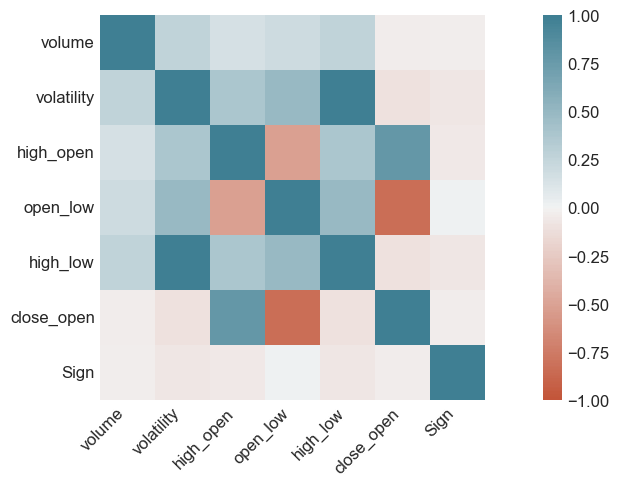

In [89]:
correla = pd.DataFrame(X_scale, index=ohlc2.index).copy()
correla['Sign'] = ohlc2['sign']
correlation_transformed = correla.corr(method='spearman')
print(correlation_transformed)

heat2 = sns.heatmap(
    correlation_transformed,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat2.set_xticklabels(
    heat2.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [90]:
X_scale

,volume,volatility,high_open,open_low,high_low,close_open
timestamp,,,,,,
2022-05-03 03:17:48,0.595999,0.036358,0.036358,0.000000,0.036358,0.343269
2022-05-03 03:17:49,0.589470,0.079015,0.029774,0.100762,0.079015,0.295192
2022-05-03 03:17:50,0.404280,0.019468,0.000000,0.039836,0.019468,0.315192
2022-05-03 03:17:51,0.660229,0.043516,0.043516,0.000000,0.043516,0.357500
2022-05-03 03:17:52,0.617206,0.084168,0.084168,0.000000,0.084168,0.384808
...,...,...,...,...,...,...
2022-05-03 03:47:43,0.634582,0.002863,0.002863,0.000000,0.002863,0.328269
2022-05-03 03:47:44,0.476578,0.030633,0.000000,0.062683,0.030633,0.307692
2022-05-03 03:47:45,0.467026,0.011165,0.007443,0.007616,0.011165,0.325769


The logistic Regression was chosen because of the type of target variable which is a binary categorical kind of feature. 
* The cost function in this case is the following one:
$$ \underset{w,c}{min}\frac{1-p}{2}{w}^{T}w+\rho||w||_1+C\sum_{i=1}^{n}log(exp(-y_i(\mathrm{X}_{i}^{T}w+c))+1) $$

This cost function is the one used for Elastic Net regularization, which is a combination of the L1 and L2 penalizations.

Next we split the dataset, as this is a timeseries we require to split it without changing the timeline or it would influence the forecasting.

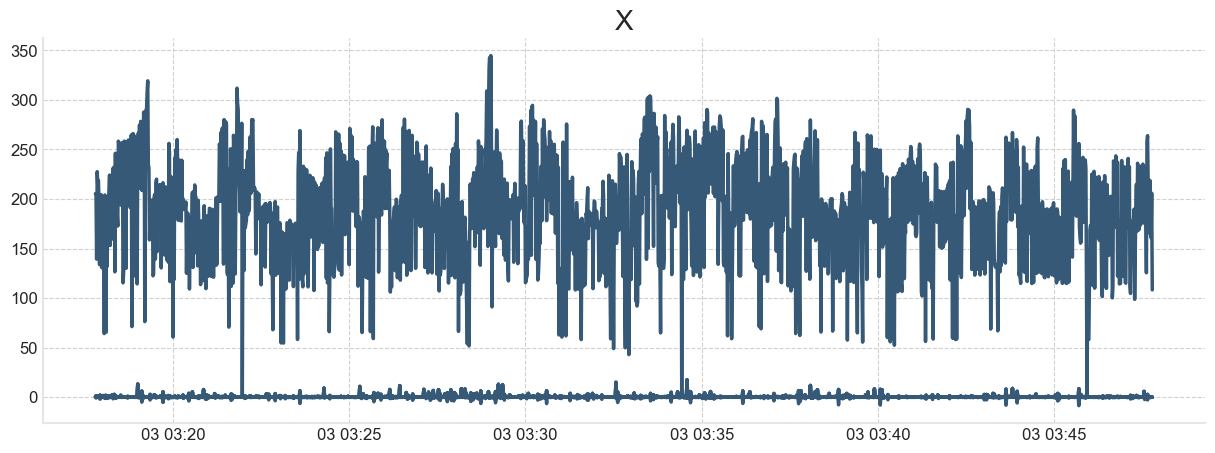

In [91]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5
plt.title('X',size=20)
plt.plot(X)


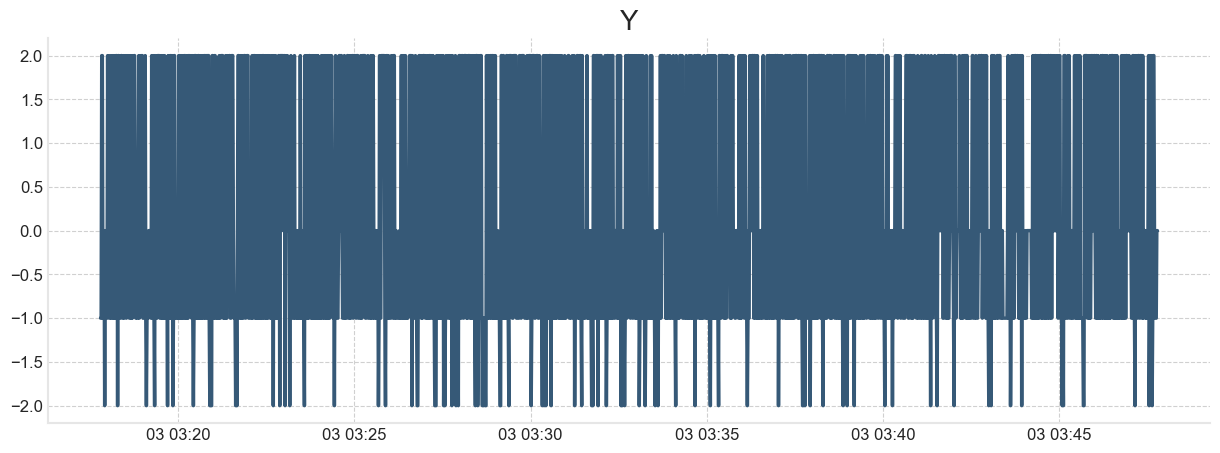

In [92]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5
plt.title('Y',size=20)
plt.plot(y)

In [94]:
test_size = int(len(X)*.20)

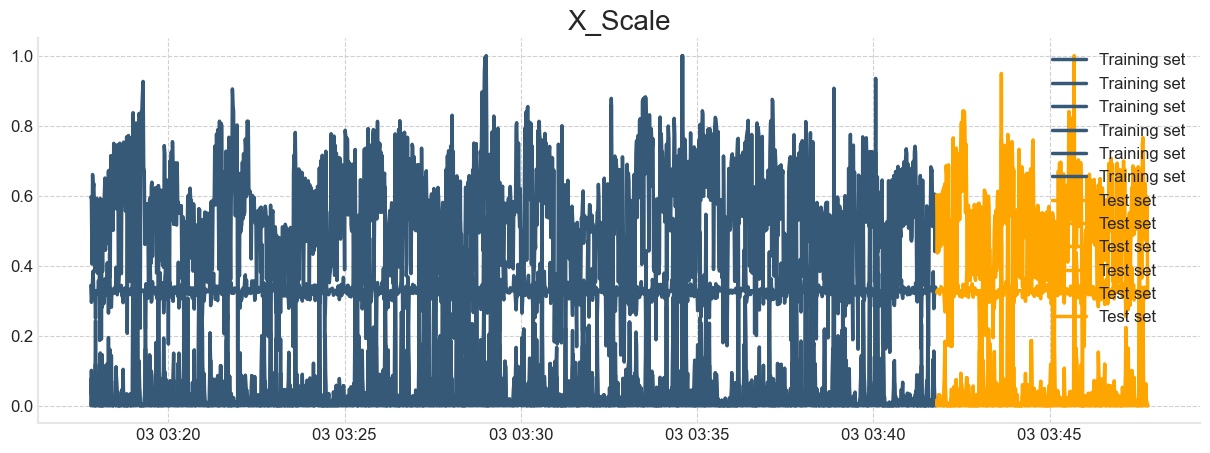

In [95]:
X_train = X_scale[:-test_size]
X_test = X_scale[-test_size:]

plt.title('X_Scale', size=20)
plt.plot(X_train, label='Training set')
plt.plot(X_test, label='Test set', color='orange')
plt.legend();

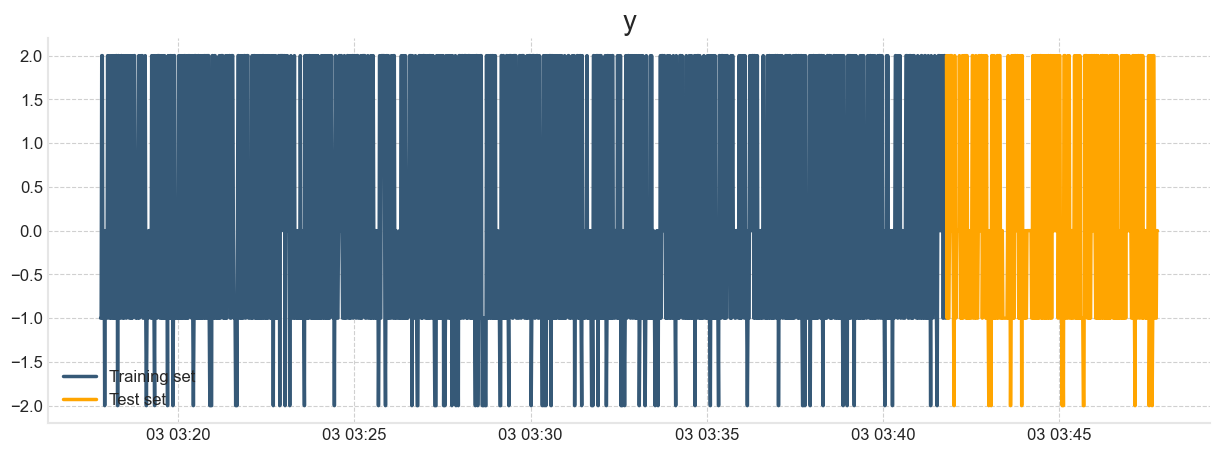

In [96]:
y_train = y[:-test_size]
y_test = y[-test_size:]

plt.title('y', size=20)
plt.plot(y_train, label='Training set')
plt.plot(y_test, label='Test set', color='orange')
plt.legend();

In [97]:
# Logistic Regression
#x_train, x_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.20,
                                                    #random_state=False)
# model fit
logistic_model = LogisticRegression(random_state=None, penalty='elasticnet',
                                    solver='saga', l1_ratio=1, max_iter=4000)
logistic_model.fit(X_train, y_train)

# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
logistic_model.score(X_normalized, y)
confusion_mat = confusion_matrix(y_test, y_pred)

In [102]:

# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
logistic_model.score(X_normalized, y)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy is", accuracy)
print("Confusion Matrix")
print(confusion_mat)


Accuracy is 37.5
Confusion Matrix
[[  0  10   0   2]
 [  0 126   0  12]
 [  0  82   0   5]
 [  0 114   0   9]]


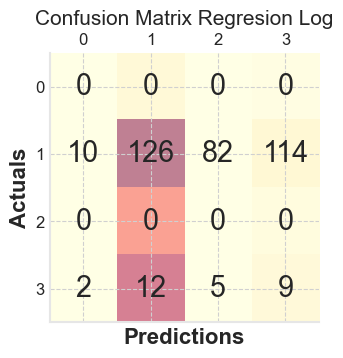

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(confusion_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mat.shape[0]):
    for n in range(confusion_mat.shape[1]):
        px.text(x=m,y=n,s=confusion_mat[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Regresion Log', fontsize=15)
plt.show()

# 4.3 Naive Bayes

In [104]:
X_train.shape, X_test.shape

((1440, 6), (360, 6))

In [105]:
import pgmpy
# instantiate the model
gnb = GaussianNB()
pgmpy


# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

In [106]:
y_pred = gnb.predict(X_test)

y_pred

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,
        0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [107]:
accuracy_naive = accuracy_score(y_test, y_pred)*100
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.2722


In [108]:
y_pred_train = gnb.predict(X_train)

In [109]:
conf_mat = confusion_matrix(y_test, y_pred)

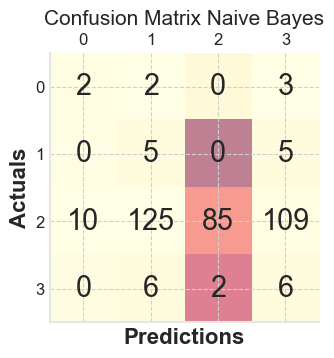

In [110]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(conf_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(conf_mat.shape[0]):
    for n in range(conf_mat.shape[1]):
        px.text(x=m,y=n,s=conf_mat[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Naive Bayes', fontsize=15)
plt.show()

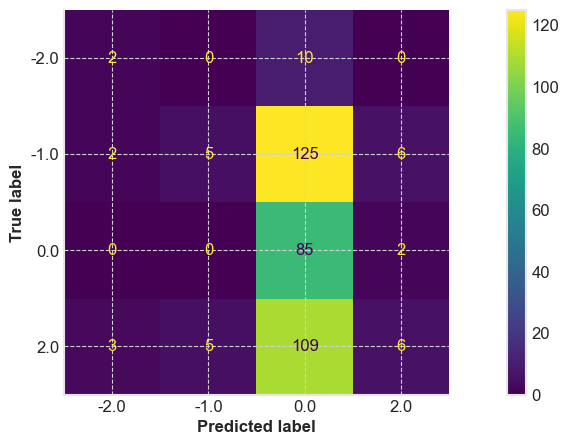

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_predictions(
  y_test, y_pred)
plt.show()

# Scores:

In [114]:
print('martingale' ,accuracy_martingala, '%')
print('Regresion', accuracy,'%')
print( 'Naive Bayes',accuracy_naive,'%')

martingale 31.444444444444446 %
Regresion 37.5 %
Naive Bayes 27.22222222222222 %


$$
\begin{aligned}
& \text {Table 1.1. Scores of the different models}\\
&\begin{array}{cccc}
\hline \hline \text { Model } & \text { Accuracy } & \text { TP} & \text { FP} & \text { FN}& \text { TN}\\
\hline Naive Bayes &0.7583 & 73 & 29 & 0 &18 \\
Martingale & print(accuracy_martingala) & 212 & 153 & 153 & 82\\
Logistic Regression & .8833333333333333 & 73 & 14 & 0 & 33\\
\hline
\end{array}
\end{aligned}
$$

# <font color= #6B6B6B> <font size = 6> 5. Symbolic Regresor Experiment</font>

Symbolic regression is a type of machine learning which aims to reveal and underlying mathematical that best describes the relationship between variables, it builds a population of random formulas to represent the relationship between variables. Then it creates generations of programs which evolve over time,and does the same process to the fittest individuals in the population. This was an experiment to create more variables to explain the model, and will be continued on the next IDI.

In [50]:
# k fault Symbolic Regressor
#x_test = pd.DataFrame(X_scale,index = X.index, columns= X.columns)
#X_train, X_test, y_train, y_test = train_test_split(x_test, y, test_size=0.20,
                                                  #  random_state=False)
